# Models with higher order kinematic components, using wrapper #

This notebook shows the user how to create a mock galaxy with higher order kinematic components such as planar and bar inflows using the wrapper. 

**Each model considered here includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion
 
And, for the non-fiducial cases: 
 - A non-circular, higher-order kinematic component
 
**The structure of the notebook is the following:**
 
 1) Setup steps
 2) Fiducial model
 3) Example 1: Uniform planar inflow
 4) Example 2: Uniform bar inflow

## 1) Setup ##

**Import modules**

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import os 

from dysmalpy.fitting_wrappers import dysmalpy_make_model, utils_io
from dysmalpy import plotting, fitting

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


**Setup notebook**

In [2]:
# Setup plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 100
mpl.rc("savefig", dpi=300)

**Set parameter, output  paths**

_Note passing a keyword argument `output` later will override the `outdir` specified in the param file._

In [3]:
# Where to save output files
outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_MODEL_WRAPPER/'
outdir = '/Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_MODEL_WRAPPER/'

# Load the parameters file from the examples directory
filepath = os.path.abspath(fitting.__file__)
param_path = os.sep.join(os.path.dirname(filepath).split(os.sep)[:-1]+["examples", "examples_param_files", "model_examples", ""])

-------------

## 2) Fiducial model ## 

First we will construct the fiducial model, with no higher order, non-circular kinematic components, for comparison to the other cases. 

In [4]:
param_filename = param_path+'make_model_3Dcube_fiducial.params'


<font size="4">**Model specification**</font>

**Preamble settings**

As with all `DysmalPy` parameter files, we first specify details about the galaxy and the instrument setup, 
which include the galaxy name, redshift, pixel scale, PSF/LSF.


In [5]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(0,42): chunk += lines[i]
    print(chunk)

# Example parameters file for fitting a single object with 1D data
# Note: DO NOT CHANGE THE NAMES IN THE 1ST COLUMN AND KEEP THE COMMAS!!
# See README for a description of each parameter and its available options.

# ******************************* OBJECT INFO **********************************
galID,    GS4_43501_fiducial    # Name of your object
z,        1.613                 # Redshift


## GALAXY CENTER:
# IMPORTANT: 0 indexed, so coordinates go from [0, nX-1] and [0, nY-1].
# So if using QFitsView, will need to subtract 1 from both coords (as QFitsView goes from [1,nX] and [1,nY])
xcenter,              None                       # Center position in cube, x coord. Default: (nX-1)/2.
ycenter,              None                       # Center position in cube, y coord. Default: (nY-1)/2.


# ***************************** OUTPUT *****************************************
outdir,           GS4_43501_3D_model_cube/         # Full path for output directory


# **************************


**We then specify the high-level details of the model.**

This includes selecting what kinds of components are included in the model. 
Here we have specified `disk+bulge`, `halo`, and `const_disp_profile`, as well as the 
always-required `geometry` and a zheight component (`zheight_gaus`). 

In [6]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(44,59): chunk += lines[i]
    print(chunk)

# **************************** SETUP MODEL *************************************

# Model Settings
# -------------
# List of components to use:  SEPARATE WITH SPACES
## MUST always keep:            geometry   zheight_gaus
## RECOMMENDED:   always keep:   disk+bulge   const_disp_prof

components_list,         disk+bulge   const_disp_prof   geometry   zheight_gaus  halo

# possible options:
#       disk+bulge, sersic, blackhole
#       const_disp_prof,   geometry,   zheight_gaus,  halo,
#       radial_flow, uniform_planar_radial_flow, uniform_bar_flow, uniform_wedge_flow,
#       unresolved_outflow



We then specify which components emit light -- here resortinig to the commonly adopted choice that it is only the galaxy disk that emits light, with a constant mass-to-light ratio. For the constant $M/L$ case, we do not need to include a separate light component, as `DysmalPy` will draw light distribution directly from the mass component. 

In [7]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(60,68): chunk += lines[i]
    print(chunk)

# List of components that emit light. SEPARATE WITH SPACES
##   Current options: disk+bulge / bulge / disk [corresponding to the mass disk+bulge component],
##              also:    light_sersic, light_gaussian_ring

light_components_list,   disk

# NOTE: if a separate light profile (eg light_sersic) is used,
#       this MUST be changed to  e.g., 'light_components_list,   light_sersic'



Further kinematic options are then specified (e.g., whether or not to use Noordermeer or halo adiabatic contraction, if pressure support is to be included, and some numerical modeling parameters). 

In [8]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(69,78): chunk += lines[i]
    print(chunk)

# Other kinematic / model settings:
adiabatic_contract,  False     # Apply adiabatic contraction?
pressure_support,    True      # Apply assymmetric drift correction?
noord_flat,          True      # Apply Noordermeer flattenning?
oversample,          3         # Spatial oversample factor
oversize,            1         # Oversize factor

zcalc_truncate,      True      # Truncate in zgal direction when calculating or not
n_wholepix_z_min,    3         # Minimum number of whole pixels in zgal dir, if zcalc_truncate=True




**Next we specify the familiar components of an axisymmetric disk+bulge and halo model with constant dispersion.** 

This includes setting up the components specifying the galaxies' geometry and z-direction light profile. 

In [9]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(80,148): chunk += lines[i]
    print(chunk)

# ********************************************************************************
# DISK + BULGE
# ------------

# Initial Values
total_mass,           11.0     # Total mass of disk and bulge log(Msun)
bt,                   0.3     # Bulge-to-Total Ratio
r_eff_disk,           5.0     # Effective radius of disk in kpc
n_disk,               1.0      # Sersic index for disk
invq_disk,            5.0      # disk scale length to zheight ratio for disk

n_bulge,              4.0      # Sersic index for bulge
invq_bulge,           1.0      # disk scale length to zheight ratio for bulge
r_eff_bulge,          1.0      # Effective radius of bulge in kpc


# ********************************************************************************
# ********************************************************************************
# ********************************************************************************
# DARK MATTER HALO
# ----------------

# Halo type: options: NFW / twopowerhalo / burkert / eina


<font size="4">**Generate `Dysmalpy` 3D model cube**</font>

With this full model setup in our parameter file, we now generate a 3D model cube.

In [10]:
dysmalpy_make_model.dysmalpy_make_model(param_filename=param_filename, 
                                        outdir=outdir, overwrite=True)

------------------------------------------------------------------
 Dysmalpy model complete for: GS4_43501_fiducial
   output folder: /Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_MODEL_WRAPPER/
------------------------------------------------------------------
 



<font size="4">**Contents of the output directory**</font>

The output directory contains a copy of the used parameter file (with the `galID` prepended), 
and the model cube FITS file.

In [11]:
import os
cmd = "ls {} | grep GS4_43501_fiducial".format(outdir)
output = os.system(cmd)

GS4_43501_fiducial_make_model_3Dcube_fiducial.params
GS4_43501_fiducial_model_cube.fits



<font size="4">**Examine/analyze model cube**</font>

The output model cube can now be examined or analyzed in any way desired (e.g., with `QFitsView`, or another script). 

As a quick visualization, we show some channel maps for this model (with contours overlaid to guide the eye).

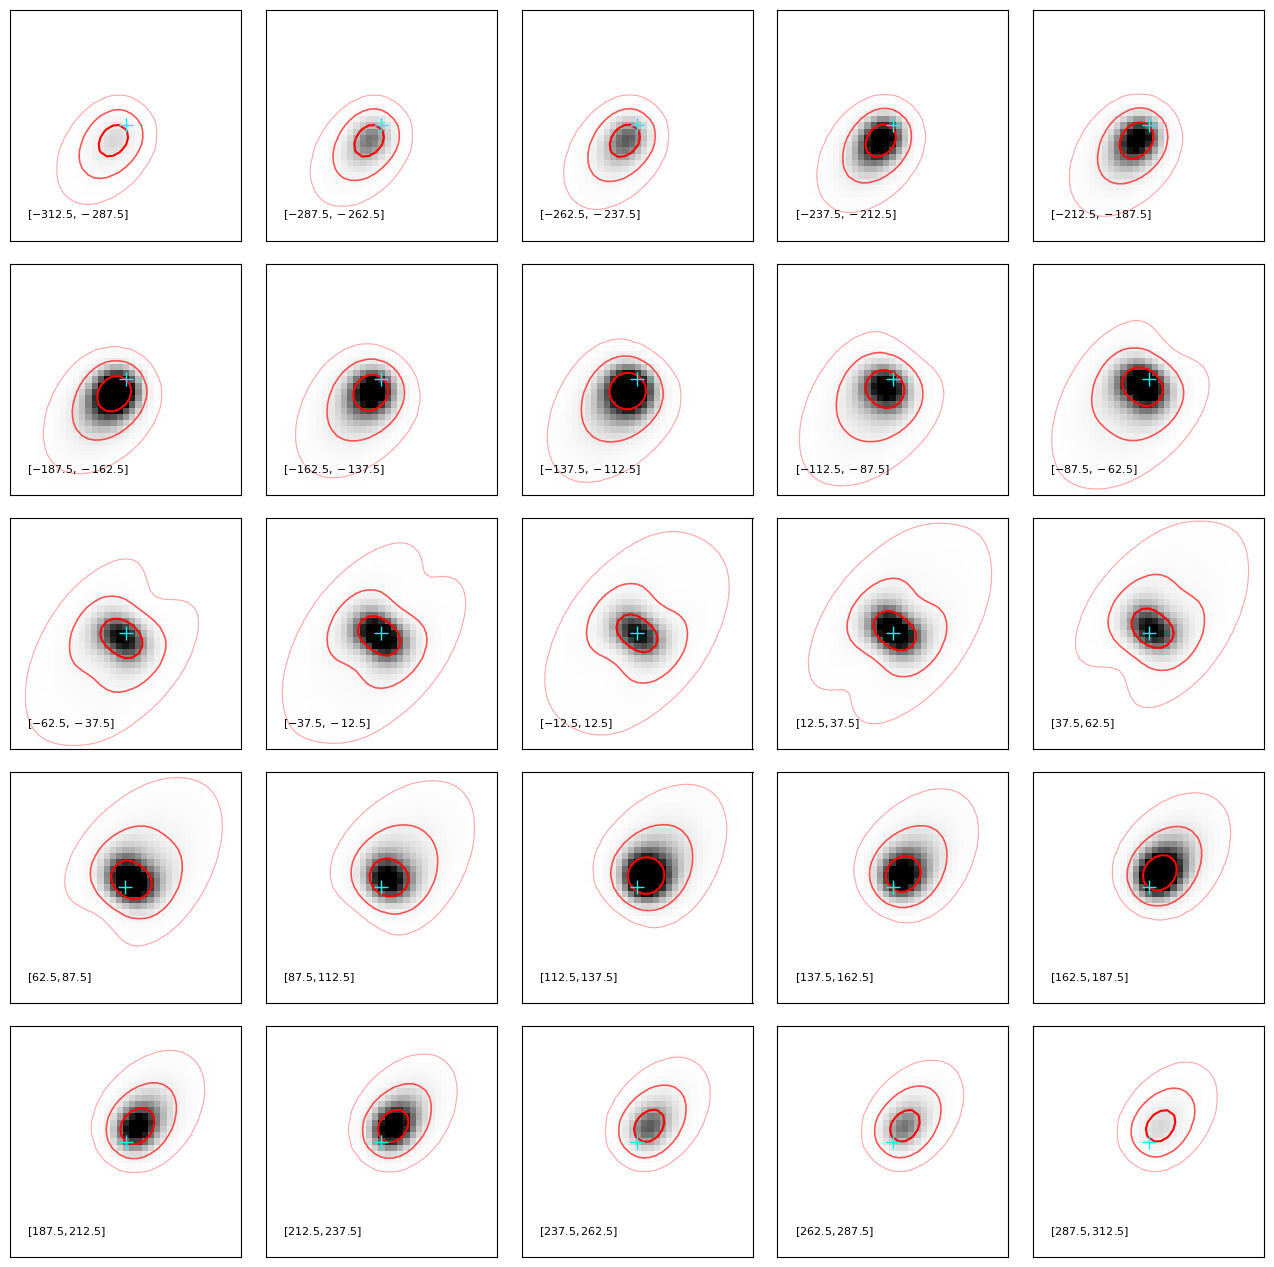

In [12]:
params = utils_io.read_fitting_params(fname=param_filename)
plotting.plot_channel_maps_cube(fname=outdir+params['galID']+'_model_cube.fits', 
                                vbounds = [-312.5, 312.5],delv=25.)

-------------

## Example 1: Uniform planar radial inflow ## 

We will now begin with an example demonstrating radial inflow within the plane of the disk, 
with constant amplitude as a function of midplane radius $R$ and azimuthal angle $\phi$.

*(There is also the option for a uniform spherical radial inflow from all directions, using the wrapper 
component named `radial_flow` instead of `uniform_planar_radial_flow`.)*

In [13]:
#param_filename = paramdir+'make_model_3Dcube_planar_radial_flow.params'

param_filename = param_path+'make_model_3Dcube_planar_radial_flow.params'


<font size="4">**Model specification**</font>


The primary model specifications (describing the axisymmetric disk+bulge+halo system) are the same for this example. 

The differences are as follows:

**1. We modify the galID and outdir.**


In [14]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(4,6): chunk += lines[i]
    print(chunk)

with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(15,18): chunk += lines[i]
    print(chunk)

# ******************************* OBJECT INFO **********************************
galID,    GS4_43501_planar_radial_flow    # Name of your object


# ***************************** OUTPUT *****************************************
outdir,           GS4_43501_planar_radial_flow_3D_model_cube/         # Full path for output directory




**2. For the high-level details, we add the higher order component.**

For this specific example, we append the ``uniform_planar_radial_flow`` component to the `components_list` paramfile entry.

(As this component is just a perturbation on the normal axisymmetric motion, we have no modifications to the `light_components_list`.)

In [15]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(44,59): chunk += lines[i]
    print(chunk)

# **************************** SETUP MODEL *************************************

# Model Settings
# -------------
# List of components to use:  SEPARATE WITH SPACES
## MUST always keep:            geometry   zheight_gaus
## RECOMMENDED:   always keep:   disk+bulge   const_disp_prof

components_list,         disk+bulge   const_disp_prof   geometry   zheight_gaus  halo  uniform_planar_radial_flow

# possible options:
#       disk+bulge, sersic, blackhole
#       const_disp_prof,   geometry,   zheight_gaus,  halo,
#       radial_flow, uniform_planar_radial_flow, uniform_bar_flow, uniform_wedge_flow,
#       unresolved_outflow




**3. Finally, we specify the higher-order, noncircular component: the uniform radial planar motion.** 

As the flow is uniform, this component only has one free parameter: `vr`, specifying the radial velocity. 

The convention for this parameter is that negative values represent inflows, while positive values are outflows.

In [16]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(152,163): chunk += lines[i]
    print(chunk)

# ********************************************************************************
# HIGHER ORDER COMPONENTS:
# ------------------------

# ********************************************************************************
# UNIFORM PLANAR RADIAL FLOW -- in Rhat direction in cylindrical coordinates
#                               (eg, radial in galaxy midplane)
# uniform_planar_radial_flow
# -------------------

vr,     -90.             # Radial flow [km/s]. Positive: Outflow. Negative: Inflow.




<font size="4">**Generate `Dysmalpy` 3D model cube**</font>
With this full model setup in our parameter file, we now generate a 3D model cube.

In [17]:
dysmalpy_make_model.dysmalpy_make_model(param_filename=param_filename, 
                                        outdir=outdir, overwrite=True)

------------------------------------------------------------------
 Dysmalpy model complete for: GS4_43501_planar_radial_flow
   output folder: /Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_MODEL_WRAPPER/
------------------------------------------------------------------
 



We now have an output cube for our example model including a uniform planar radial inflow (along with a copy of the corresponding param file).

In [18]:
import os
cmd = "ls {} | grep GS4_43501_planar_radial_flow".format(outdir)
output = os.system(cmd)

GS4_43501_planar_radial_flow_make_model_3Dcube_planar_radial_flow.params
GS4_43501_planar_radial_flow_model_cube.fits



<font size="4">**Examine/analyze model cube**</font>

For this example, the channel maps exhibit a "twisting" -- seen most clearly in the central channel centered on $V=0$.

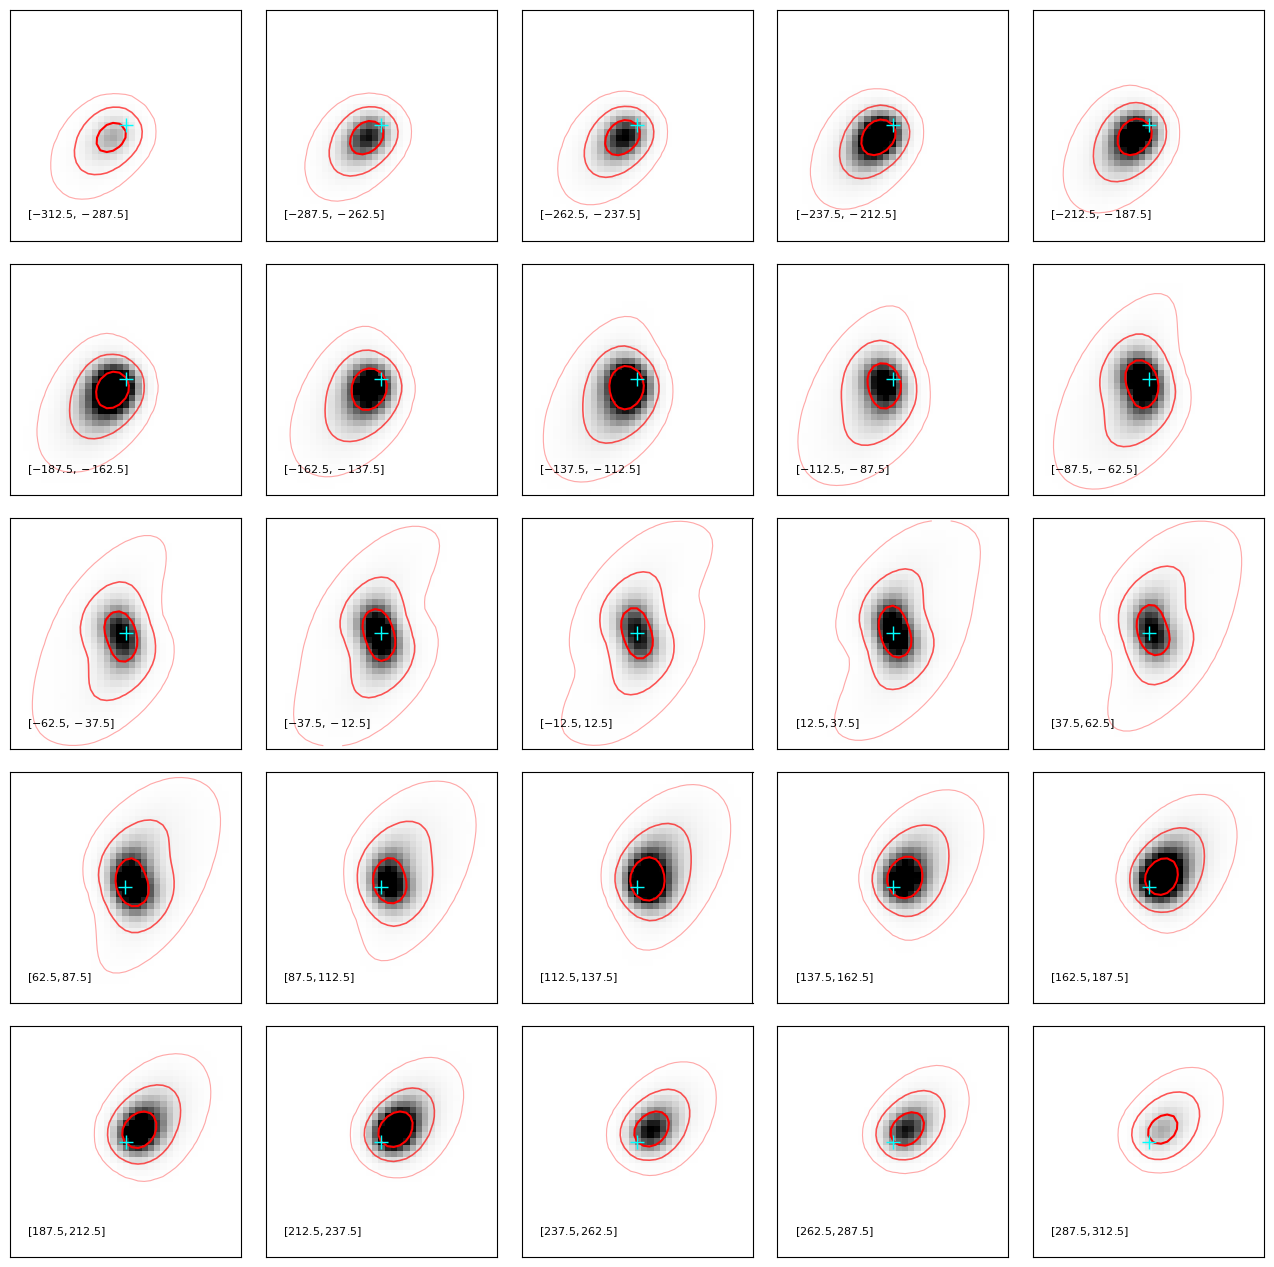

In [19]:
params = utils_io.read_fitting_params(fname=param_filename)
plotting.plot_channel_maps_cube(fname=outdir+params['galID']+'_model_cube.fits', 
                                vbounds = [-312.5, 312.5],delv=25.)

------

## Example 2: Uniform bar inflow ## 

Next we'll look at a uniform inflow along a bar. 

The bar has an azimuthal angle $\phi$ relative to the galaxy major axis (where $\phi=90^{\circ}$ has the bar along the minor axis), a (full) $\mathrm{width_{bar}}$ in $\mathrm{kpc}$ (extending from $[-\mathrm{width_{bar}}/2, \mathrm{width_{bar}}]$ in the bar $y$ direction), 
and an infinite length. 

The amplitude of the flow is uniform as a function of position along the bar, but always points inwards/outwards in the bar's $x$ direction (depending on the sign of $V_{\mathrm{bar}}$).


In [20]:
param_filename = param_path+'make_model_3Dcube_bar_flow.params'


<font size="4">**Model specification**</font>


As in the previous example, this model differs from the fiducial case as follows: 

**1. We modify the galID and outdir.**


In [21]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(4,6): chunk += lines[i]
    print(chunk)

with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(15,18): chunk += lines[i]
    print(chunk)

# ******************************* OBJECT INFO **********************************
galID,    GS4_43501_bar_flow    # Name of your object


# ***************************** OUTPUT *****************************************
outdir,           GS4_43501_bar_flow_3D_model_cube/         # Full path for output directory




**2. For the high-level details, we add the higher order component.**

For this specific example, we append the ``uniform_bar_flow`` component to the `components_list` paramfile entry.

(As this component is just a perturbation on the normal axisymmetric motion, we have no modifications to the `light_components_list`.)

In [22]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(44,59): chunk += lines[i]
    print(chunk)

# **************************** SETUP MODEL *************************************

# Model Settings
# -------------
# List of components to use:  SEPARATE WITH SPACES
## MUST always keep:            geometry   zheight_gaus
## RECOMMENDED:   always keep:   disk+bulge   const_disp_prof

components_list,         disk+bulge   const_disp_prof   geometry   zheight_gaus  halo  uniform_bar_flow

# possible options:
#       disk+bulge, sersic, blackhole
#       const_disp_prof,   geometry,   zheight_gaus,  halo,
#       radial_flow, uniform_planar_radial_flow, uniform_bar_flow, uniform_wedge_flow,
#       unresolved_outflow




**3. Finally, we specify the higher-order, noncircular component: the uniform bar flow.** 

For this case, the velocity amplitude does not vary with position along the bar, so it is specified by only `vbar`. 

As with the radial inflows, the convention is that negative values represent inflows, while positive values are outflows.

We speficy the bar geometry using `phi`, the azimuthal angle of the bar relative to the galaxy major axis, and `bar_width`, the full width of the bar (perpendicular to the bar motion direction) in kpc.

In [23]:
with open(param_filename, 'r') as f:
    lines=f.readlines()
    chunk=""
    for i in range(152,167): chunk += lines[i]
    print(chunk)

# ********************************************************************************
# HIGHER ORDER COMPONENTS:
# ------------------------

# ********************************************************************************
# UNIFORM BAR FLOW -- in xhat direction along bar in cartesian coordinates,
#                     with bar at an angle relative to galaxy major axis (blue)
# uniform_bar_flow
# -------------------

vbar,     -90.             # Bar flow [km/s]. Positive: Outflow. Negative: Inflow.
phi,       90.             # Azimuthal angle of bar [degrees], counter-clockwise from blue major axis.
                           # Default is 90 (eg, along galaxy minor axis)
bar_width,  5              # Width of the bar perpendicular to bar direction.
                           # Bar velocity only is nonzero between -bar_width/2 < ygal < bar_width/2.




<font size="4">**Generate `Dysmalpy` 3D model cube**</font>
With this full model setup in our parameter file, we now generate a 3D model cube.

In [24]:
dysmalpy_make_model.dysmalpy_make_model(param_filename=param_filename, 
                                        outdir=outdir, overwrite=True)

------------------------------------------------------------------
 Dysmalpy model complete for: GS4_43501_bar_flow
   output folder: /Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_MODEL_WRAPPER/
------------------------------------------------------------------
 



We now have an output cube for our example model including a uniform planar radial inflow (along with a copy of the corresponding param file).

In [25]:
import os
cmd = "ls {} | grep GS4_43501_bar_flow".format(outdir)
output = os.system(cmd)

GS4_43501_bar_flow_make_model_3Dcube_bar_flow.params
GS4_43501_bar_flow_model_cube.fits



<font size="4">**Examine/analyze model cube**</font>

For this example, the twisting isn't as pronounced for the uniform planar inflow, but twistinig can still be seen in the angle of the centermost contours at the low $|V|$ channels. We can also see deviations from reflection symmetry about the galaxy major axis in the outer contours.

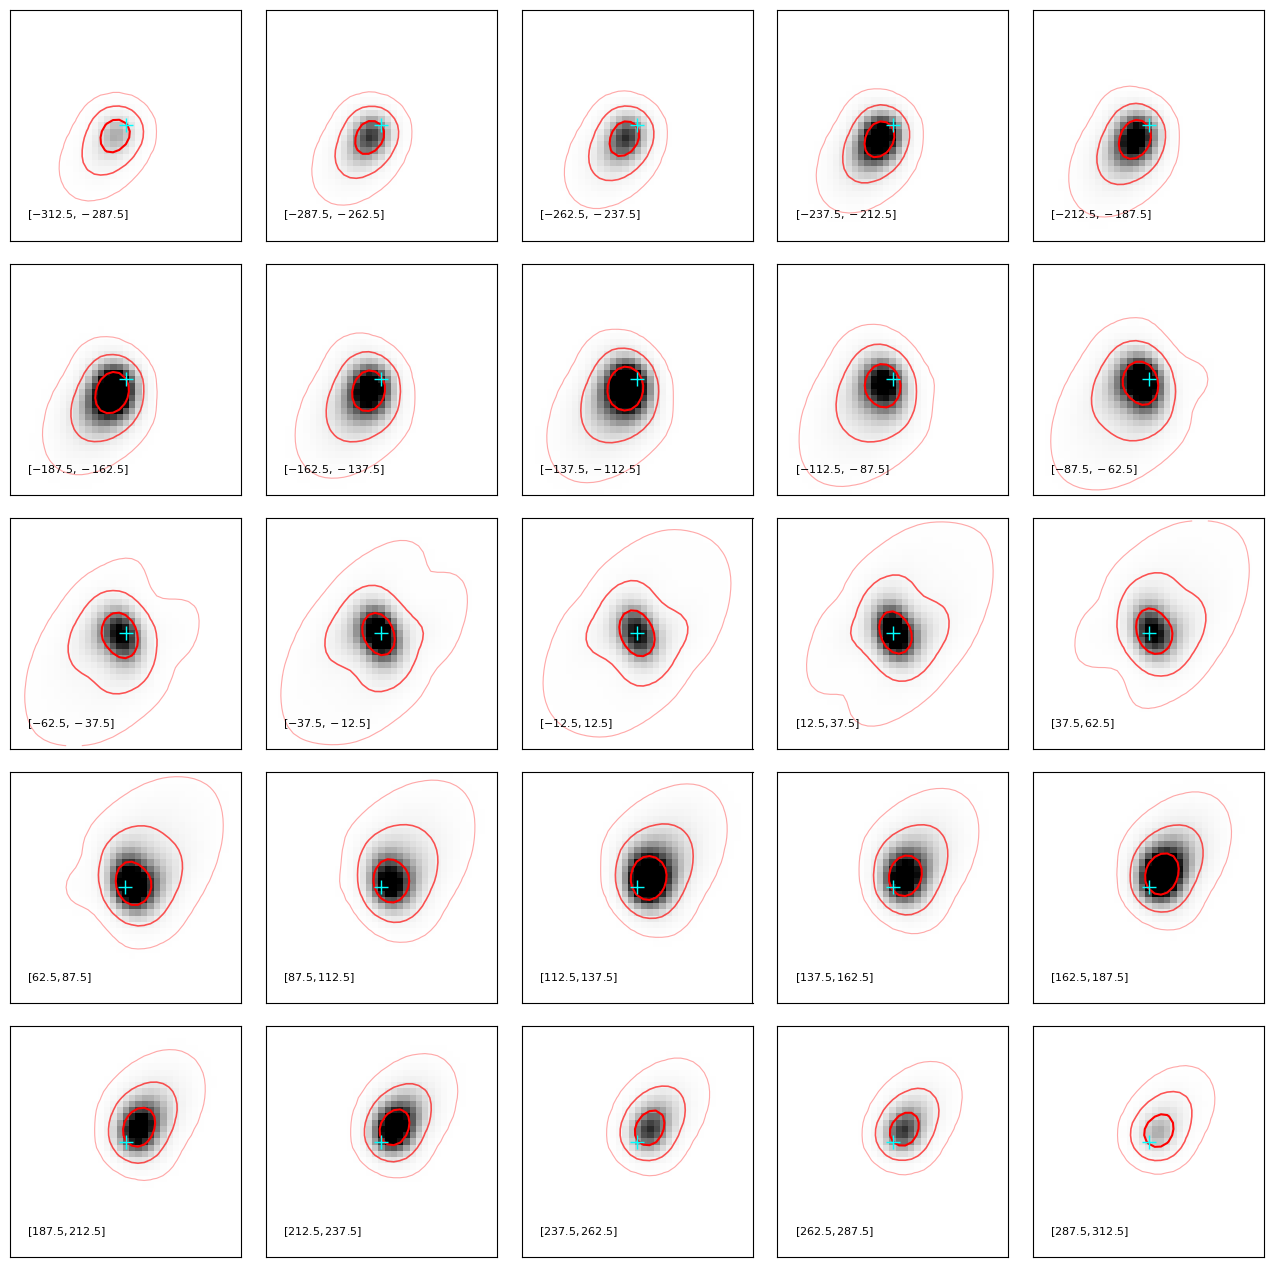

In [26]:
params = utils_io.read_fitting_params(fname=param_filename)
plotting.plot_channel_maps_cube(fname=outdir+params['galID']+'_model_cube.fits', 
                                vbounds = [-312.5, 312.5],delv=25.)

------

## Running the model-generation wrapper ##

### Windows ### 

For Windows environments, models are generated by running the ``make_model_dysmalpy.bat`` script and selecting the desired parameter file. 

### Command line usage ###

To run this script from the command line (e.g, *nix environments), you will need to know the full install path to the DysmalPy fitting wrapper directory.

Additionally, you will need to fully specify all output paths, etc, directly in the parameter file.

The syntax for using this from the command line is as follows: 

```console
$ python /PATH/TO/DPY/INSTALL/dysmalpy/fitting_wrappers/dysmalpy_make_model.py make_model_3Dcube_fiducial.params
```

(Note also that `/PATH/TO/DPY/INSTALL/` must be adjusted for your specific DysmalPy install location. 
Finally, the above assumes that the python executable is within your `$PATH`. If this is not the case, you will need to specify the full path to the pythone executable as well.)

### Within python ###

Finally, this wrapper can be used from within a python session or python script. The usage is exactly as shown in this tutorial (where the wrapper is imported as `from dysmalpy.fitting_wrappers import dysmalpy_make_model`, and so on).